# [IAPR][iapr]: Project


**Group ID:** 32

**Author 1 (350508):** Ziyi ZHAO  
**Author 2 (321657):** Yujie HE  
**Author 3 (337088):** Xufeng GAO  

**Release date:** 02.02.2022


## Important notes

The assignments are designed to teach practical implementation of the topics presented during class as well as preparation for the final project, which is a practical project which ties together the topics of the course. 

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook !** rerun the notebook from scratch `Kernel` > `Restart & Run All`


[iapr]: https://github.com/LTS5/iapr

---
## 0. Introduction

An anonymous card player that we will name Bartick Pruel is willing to improve his poker skills. To do so, he asked our lab to design a tool that will automatically detect the hands of the players around the table. 

---

## 1. Data

To achieve your task, you will be given images that look like this (without the overlay)


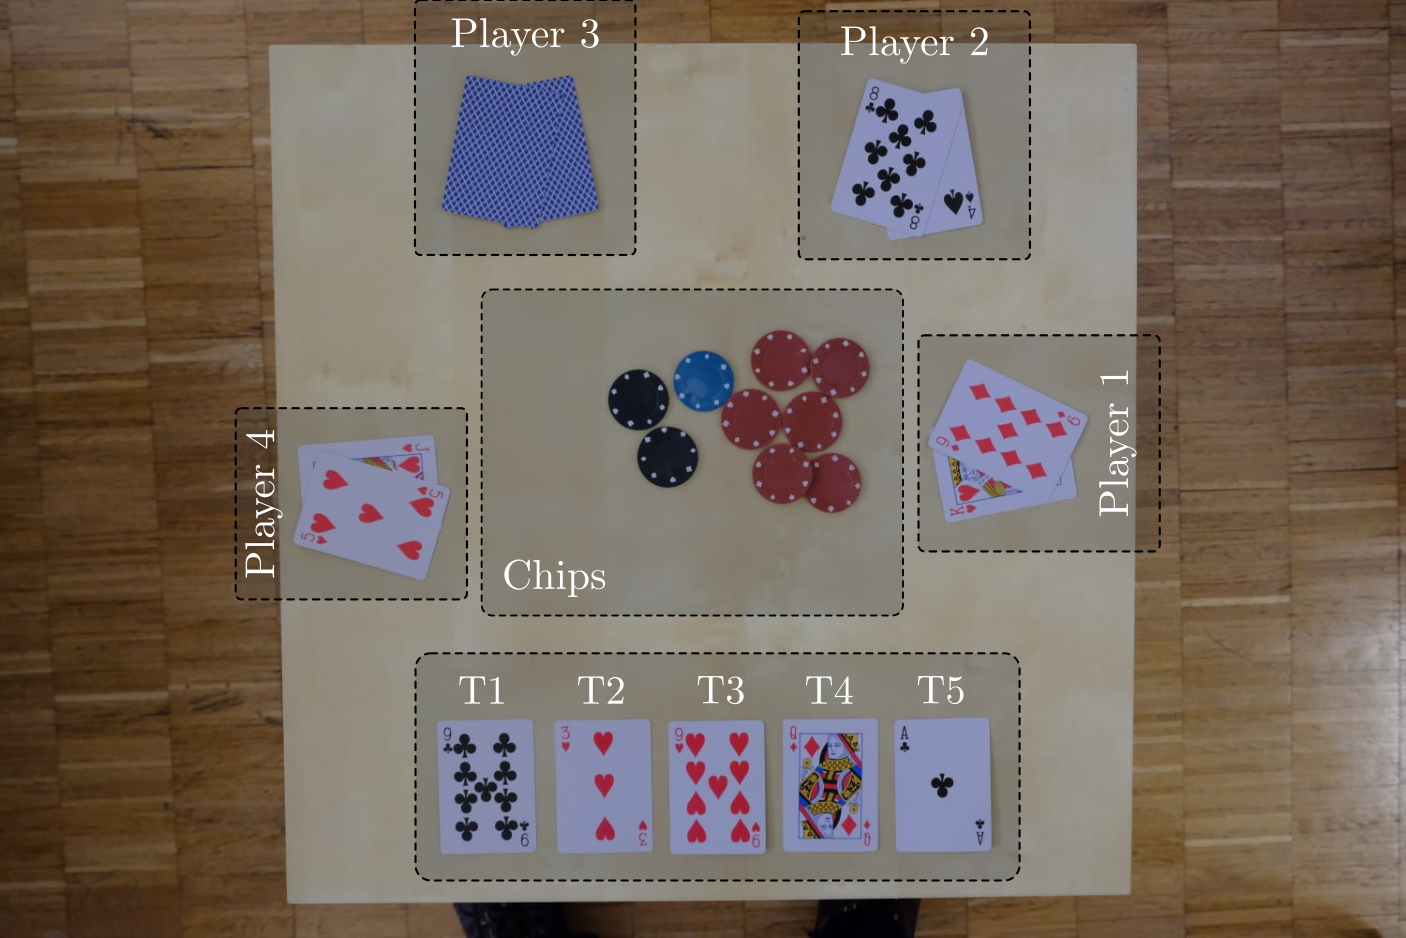

### 1.1. Table layout

The table is divided into 3 main parts:
* **Table cards (T1-T5)**: These cards are shared by every player. They are defined as the flop (T1-T3), the turn (T4) and the river (T5). The table cards are *always* visible.
* **Player cards (P11-P42)**: The cards played by each player (4 pairs). Each player *always* has 2 cards in hand. When a player is not playing, you can see the back of the cards (ex: player 3 here).
* **Chips**: The chips at the center of the table are named the pot.

### 1.2. Cards & Chips

The cards deck are composed of 52 cards split into 4 different colors: (D)imanond, (H)eart, (S)pade, (C)lub. Each color is composed of 13 different cards: 2, 3, 4, 5, 6, 7, 8, 9, 10, (J)ack, (Q)ueen, (K)ing and (A)ce.

Th chips can be of 5 different colors: (r)ed, (g)reen, (b)lue, blac(k) or (w)hite.


### 1.3 Structure

You can download the data for the project here: [download data](https://drive.google.com/file/d/1d7rOe88kEK1CEaLvYgNZkxrtKImLVC9X/view)


---

## 2. Tasks


Your task is to predict the following parameters for a set of images.

* **T1** (str): String code of the first card of the flop (far left) 
* **T2** (str): String code of the second card of the flop
* **T3** (str): String code of the third card of the flop
* **T4** (str): String code of the turn
* **T5** (str): String code of the river


* **P11** (str or int): String code of player 1 card 1. Should be 0 if player 1 is not Playing.
* **P12** (str or int): String code of player 1 card 2. Should be 0 if player 1 is not Playing.
* **P21** (str or int): String code of player 2 card 1. Should be 0 if player 2 is not Playing.
* **P22** (str or int): String code of player 2 card 2. Should be 0 if player 2 is not Playing.
* **P31** (str or int): String code of player 3 card 1. Should be 0 if player 3 is not Playing.
* **P32** (str or int): String code of player 3 card 2. Should be 0 if player 3 is not Playing.
* **P41** (str or int): String code of player 4 card 1. Should be 0 if player 4 is not Playing.
* **P42** (str or int): String code of player 4 card 2. Should be 0 if player 5 is not Playing.


* **CR** (int): Number of (r)ed chips in the pot
* **CG** (int): Number of (g)reen chips in the pot
* **CB** (int): Number of (b)lue chips in the pot
* **CK** (int): Number of blac(k) chips in the pot
* **CW** (int): Number of (w)hite chips in the pot


The output is saved using the function **save_results** as presented below.

---





## 3. Evaluation

**Before the exam**
   - Create a zipped folder named **groupid_xx.zip** that you upload on moodle (xx being your group number).
   - Include a **runnable** code (Jupyter Notebook and external files) and your presentation in the zip folder.
   
**The day of the exam**
   - You will be given a **new folder** with few images, but **no ground truth** (csv file).
   - We will ask you to run your pipeline in **real time** and to send us your prediction of the task you obtain with the provided function **save_results**. 
   - On our side, we will compute the performance of your classification algorithm. 
   - To evaluate your method, we will use the **evaluate_game** function presented below. To understand how the provided functions work, please read the documentation of the functions in **utils.py**.
   - **Please make sure your function returns the proper data format to avoid points penalty on the day of the exam**. 
---

## 4. Our pipeline


### Image cutting / Area Labelling

In [2]:
# std
from typing import Union, List, Dict
from glob import glob
import warnings
warnings.filterwarnings("ignore")
import os,sys

# imported
import cv2 as cv
import matplotlib.pyplot as plt
import PIL.Image
import numpy as np
import pandas as pd
from termcolor import colored
from treys import Card

# custom
from utils import eval_listof_games , debug_listof_games, save_results , load_results
from viz_utils import plotMultipleImages, vizCropProcedures
from preprocess_utils import cropTable, cropImgParts, PART_NAMES
from chip_utils import getChipRes
from card_utils import checkNoPlay, extractTableCard, getPlayerRes, checkPlaying, checkPlayingSplit
from data_utils import getGameDict

In [3]:
project_dir_path = os.path.dirname(os.path.realpath("__file__"))

In [4]:
# Global variables and functions
data_path = "data/train"
train_size = np.loadtxt(os.path.join(data_path, "train_size.txt")).astype(int)
file = os.path.join(data_path, f"train_{str(0).zfill(2)}.jpg")
im_origin = PIL.Image.open(file)

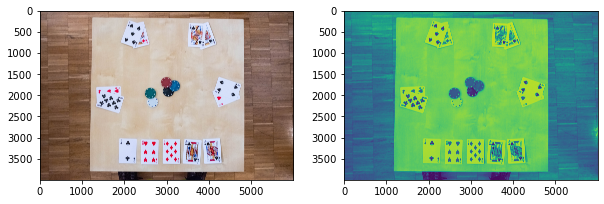

In [5]:
# Visualization
plt.figure(figsize=(10,10))
plt.subplot(1,2,1) 
plt.imshow(im_origin)
plt.subplot(1,2,2)
imgGrey = im_origin.convert('L')
plt.imshow(imgGrey)
plt.show()

### Extracting the desktop and creating a uniform coordinate system

In [6]:
from preprocess_utils import (
    addRectOffset,
    scaleRect,
    transRect,
    cropRectFromImg,
    preprocessImg,
    cropTableFromPre,
    cropTable,
)

#### Example of processing single image

crop size (3634, 3569, 3)
crop image aspect ratio 1.0182123844214066


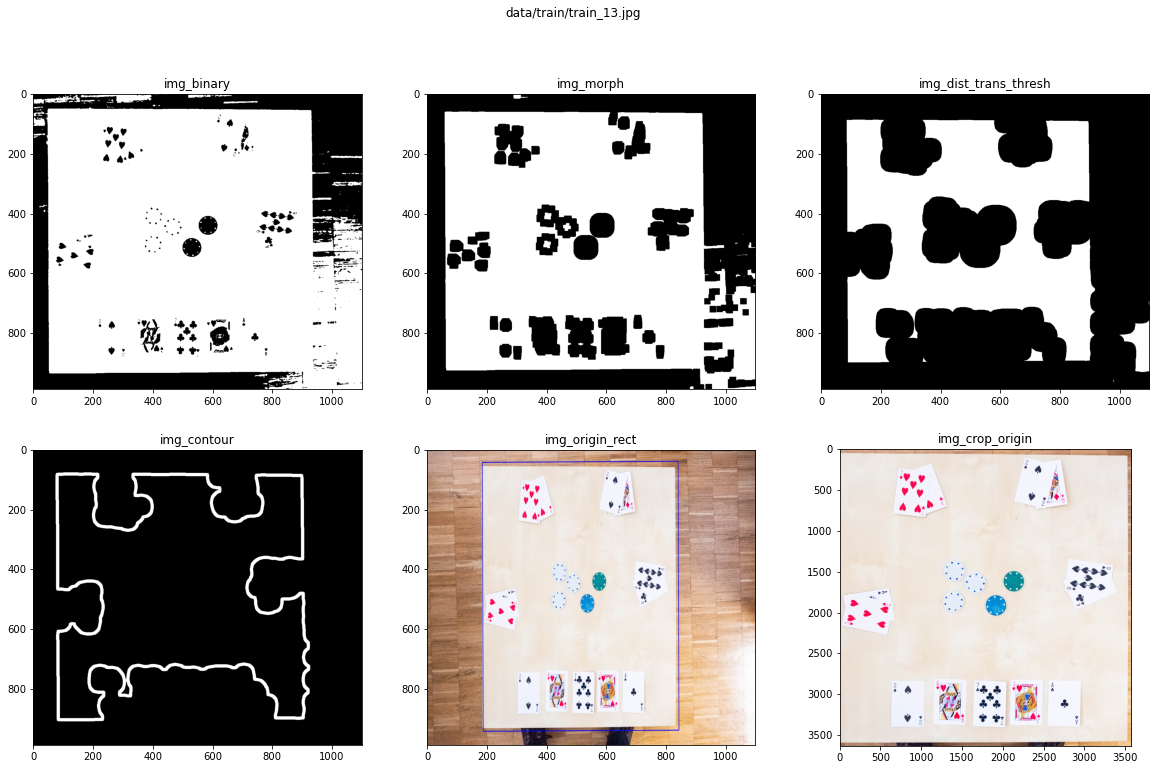

In [7]:
debug=True
test_files = [
    'data/train/train_13.jpg',
]
for file in test_files:
    img_crop_origin, rect, rect_origin, imgs_debug = cropTable(                                                                         
        file,
        kernel_sz=3,
        dist_thresh=0.2,
        edge_dilate_nr=5,
        use_convex_hull=False,
        resize_flag=True,
        resize_scale=4.0,
        crop_sz=(800, 20),
        rect_offset=70,
        debug=debug,
    )
    
    if debug:
        vizCropProcedures(imgs_debug, img_crop_origin, figsize=(20, 12), main_title=file)

#### Example of processing batch images

In [8]:
debug=False

tables_crop = []
for i in range(train_size):
    # print('Image number: {}'.format(i))
    file = os.path.join(data_path, f"train_{str(i).zfill(2)}.jpg") 
    
    table_crop_origin, rect, rect_origin, imgs_debug = cropTable(                                                                         
        file,
        kernel_sz=3,
        dist_thresh=0.2,
        edge_dilate_nr=5,
        use_convex_hull=False,
        resize_flag=True,
        resize_scale=4.0,
        crop_sz=(800, 20),
        rect_offset=70,
        debug=debug,
    )
    tables_crop.append(table_crop_origin)
    
    if debug:
        vizCropProcedures(imgs_debug, table_crop_origin, figsize=(20, 12), main_title=file)
print('Finish cropping tables')

Finish cropping tables


### Extraction of different label areas in the table

In [9]:
from preprocess_utils import cropImgParts, PART_NAMES

#### Example of crop parts of single image

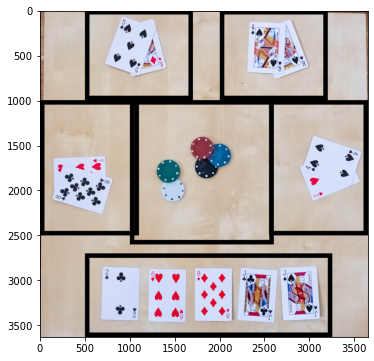

In [10]:
test_table_crop = tables_crop[0]
test_im_parts = cropImgParts(test_table_crop, viz_inplace=True, fig_title=None)

#### Example of crop parts of all images

In [11]:
viz_parts=False
viz_inplace=False
# im_parts_dict = {im_name: [] for im_name in PART_NAMES}
img_parts_list = []
for img_id, table_crop in enumerate(tables_crop):
    test_im_parts = cropImgParts(
        table_crop, 
        viz_parts=viz_parts, 
        viz_inplace=viz_inplace,
        fig_title='Image '+str(img_id)
    )
    img_parts_list.append(test_im_parts)
#     for idx, im_name in enumerate(PART_NAMES):
#         im_parts_dict[im_name].append(test_im_parts[idx])
print('Finish cropping parts')

Finish cropping parts


### Detect chips with different number and colors

#### Example of detecting single image

In [12]:
# from chip_utils import getChipRes

results: [1, 1, 1, 1, 1]


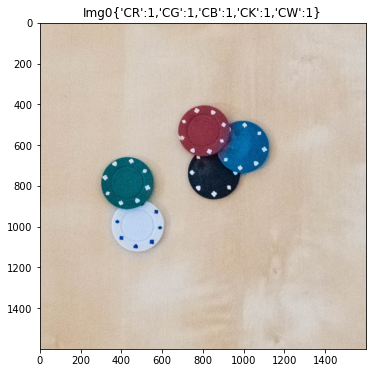

In [13]:
test_id = 0
img_chip_np = np.asarray(img_parts_list[test_id][5])
getChipRes(
    img_chip = img_chip_np, 
    img_id = test_id,
    viz_res=True,
    debug=False,
)
print('results:', [getGameDict(test_id)[key] for key in ['R', 'G', 'B', 'K', 'W']])

#### Example of detecting batch of all images

In [14]:
viz_res = False
imgs_chip = [np.asarray(img_parts_list[i][5]) for i in range(len(img_parts_list))]
for img_id, img_chip in enumerate(imgs_chip):
    getChipRes(
        img_chip = img_chip, 
        img_id = img_id,
        viz_res=viz_res,
        debug=False,
    )
    if viz_res:
        print('results:', [getGameDict(img_id)[key] for key in ['R', 'G', 'B', 'K', 'W']])
print('Finish detecting chips')

Finish detecting chips


### Extract table cards

####  Example of crop 5 parts of single image

In [15]:
# from card_utils import extractTableCard

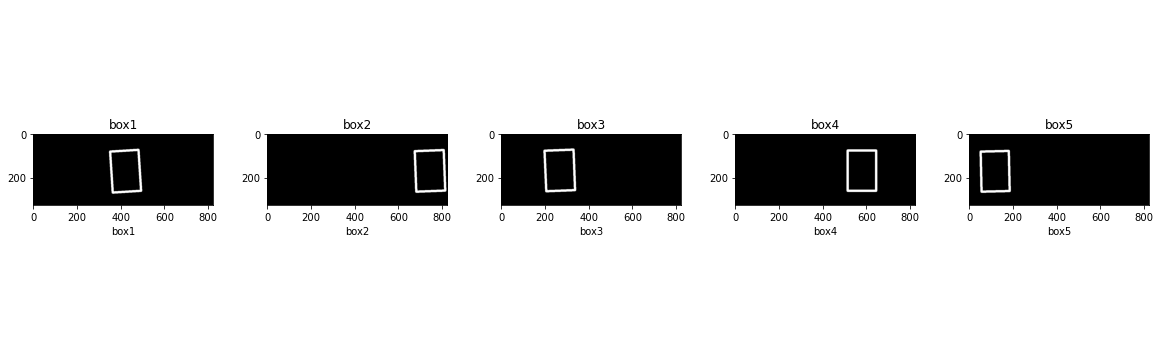

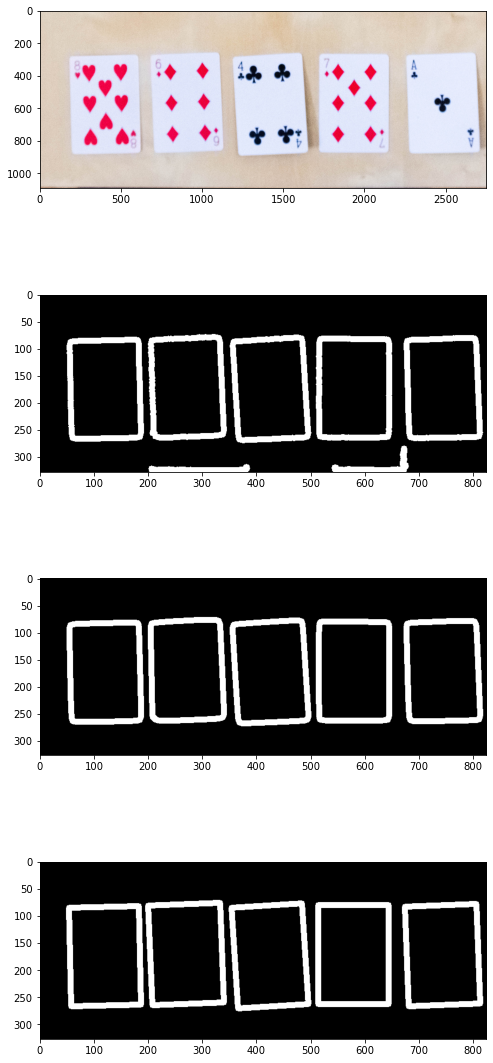

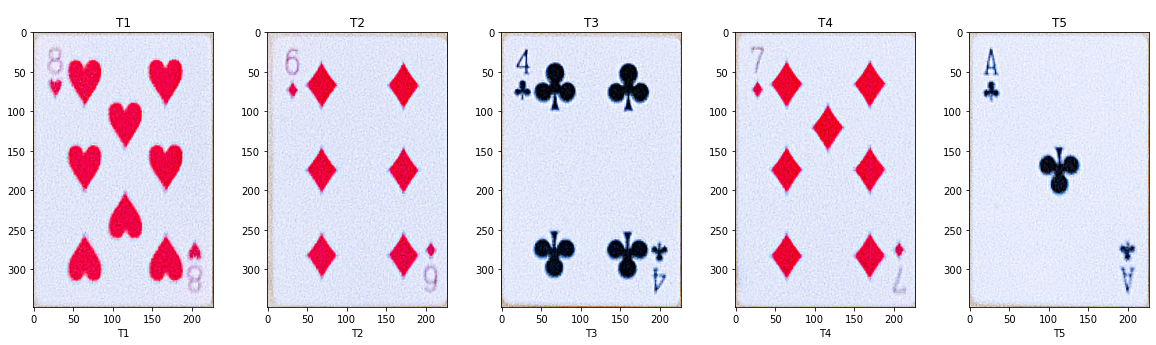

In [16]:
test_id = 5
img_part_t = np.asarray(img_parts_list[test_id][4])
test_img_table_cards = extractTableCard(img_part_t=img_part_t, debug=True)

#### Example of crop 5 parts of batch images

In [17]:
img_table_cards_list = []
for idx, im_parts in enumerate(img_parts_list):
    img_part_t = np.asarray(im_parts[4])
    img_table_cards = extractTableCard(img_part_t=img_part_t, debug=False)
    img_table_cards_list.append(img_table_cards)
print('Finish extracting table cards')

Finish extracting table cards


### Detect table cards

In [18]:
from yolodetector.detect import detectFromNp, loadYoloModel
from detect_utils import detectTableCard

#### Example of simple image

{'T1': '7H', 'T2': '7H', 'T3': '4C', 'T4': '7D', 'T5': 'AC'}


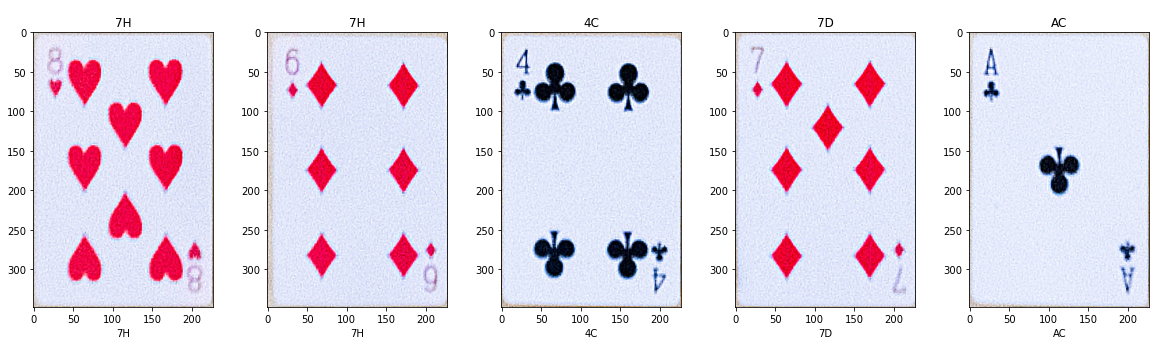

In [19]:
debug = True
model = loadYoloModel()
img_table_cards = test_img_table_cards

t15_results = detectTableCard(img_table_cards, model, debug=debug)

#### Example of batch images

In [20]:
debug = False
model = loadYoloModel()
import time
start = time.time()
for idx, img_table_cards in enumerate(img_table_cards_list):
    # print(idx)
    detectTableCard(img_table_cards, model, debug=debug)
end = time.time()
print("Average processing time of YOLO detector to 140 images:", (end-start)/140)

Average processing time of YOLO detector to 140 images: 0.06600234167916434


### Extract player cards

#### Extraction of single player cards image

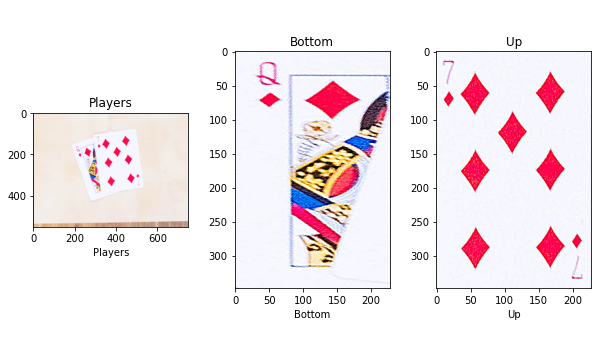

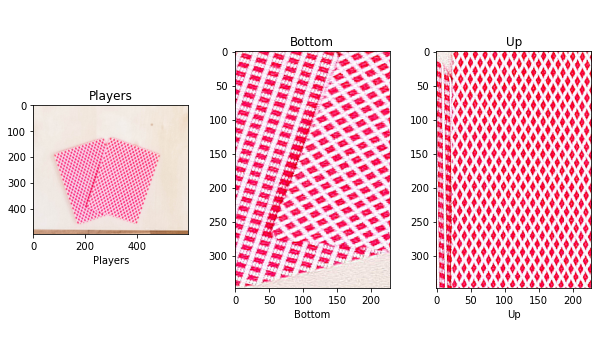

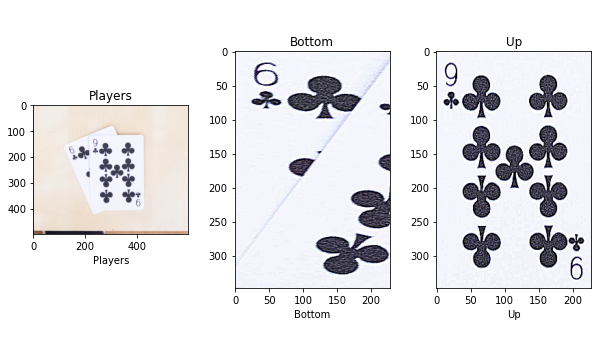

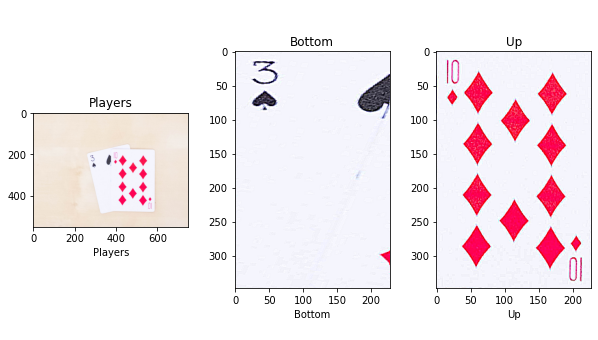

In [21]:
debug = True
img_player_card_parts = [np.array(im) for im in test_im_parts[:4]]

test_img_player_cards = getPlayerRes(
    img_players=img_player_card_parts,
    img_ID=img_id,
    debug=debug,
)

#### Extraction of batch player cards images

In [22]:
debug = False
img_player_cards_list = []
for im_parts in img_parts_list:
    img_player_card_parts = [np.array(im) for im in im_parts[:4]]

    img_player_cards = getPlayerRes(
        img_players=img_player_card_parts,
        img_ID=img_id,
        debug=debug,
    )
    img_player_cards_list.append(img_player_cards)
print("Finish extract all player cards")

Finish extract all player cards


### Detect player cards

In [23]:
from detect_utils import detectPlayerCard

- Detect whole part image

In [24]:
# debug = True
# img_player_cards = img_player_card_parts
# model = loadYoloModel()

# player_list = []
# for idx, img_player_card in enumerate(img_player_cards):

#     test_img = PIL.Image.fromarray(img_player_card)
#     detected_res = detectFromNp(
#         test_img,
#         model,
#     )
#     if detected_res != {}:
#         # str_code = max(detected_res, key=detected_res.get)
#         max_conf = max(detected_res.keys())
#         str_code = detected_res[max_conf]
#     else:
#         str_code = 'NotDetected'
#     print(detected_res)
#     player_list.append(str_code)
# player_res = {'P' + str(idx//2 + 1) + str(idx%2 + 1): player_list[idx] for idx in range(len(player_list))}
# if debug:
#     print(player_res)
#     plotMultipleImages(
#         1,
#         4,
#         images=img_player_cards,
#         titles=player_list,
#         cmap=['rgb'] * 8,
#         figsize=(20, 10),
#     )

{'P11': '2H', 'P12': '4S', 'P21': '0', 'P22': 'QC', 'P31': 'AD', 'P32': '5S', 'P41': '7H', 'P42': '8C'}


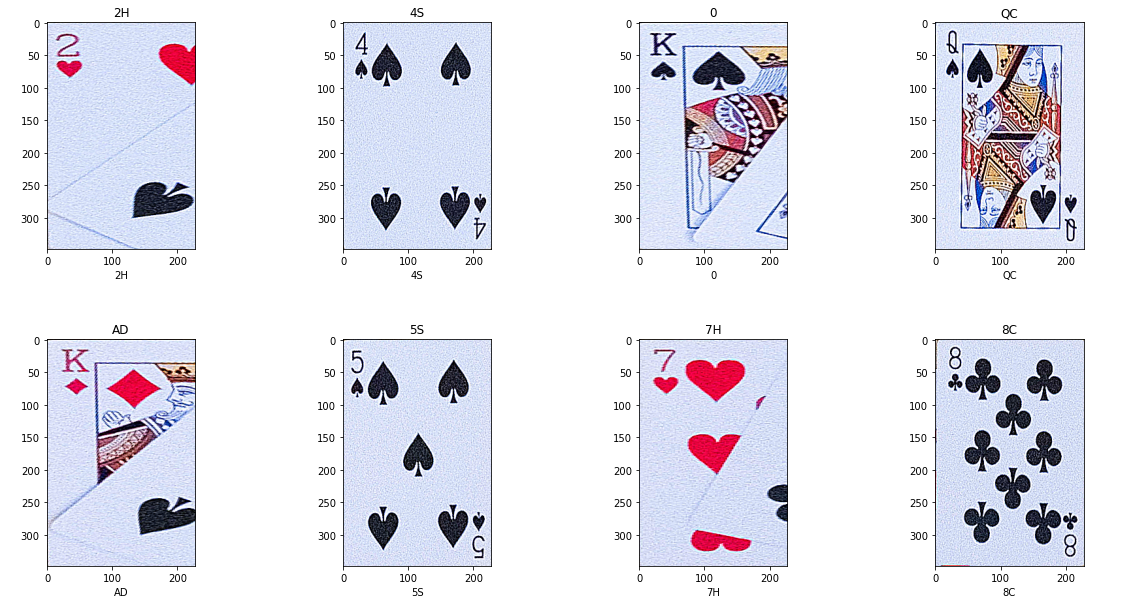

In [25]:
debug = True
img_id = 0
model = loadYoloModel()

# check player status
img_players = [np.array(im) for im in img_parts_list[img_id][:4]]
playing_status = checkPlaying(img_players, debug=False)

# detect player card
img_player_cards = img_player_cards_list[img_id]
player_res =  detectPlayerCard(
    img_player_cards = img_player_cards,
    playing_status = playing_status,
    model=model,
    debug=debug,
)

### Check not-playing

> Should be 0 if player is not Playing.

#### Check playing with whole images

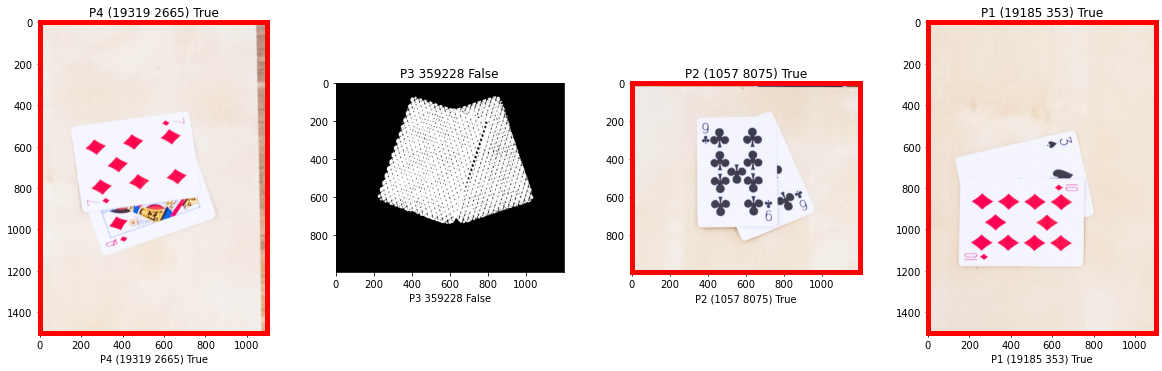

In [26]:
# img_players = test_im_parts[:4]
# playing_status = checkNoPlay(img_players, debug=True)
img_players = [np.array(im) for im in test_im_parts[:4]]
playing_status = checkPlaying(img_players, debug=True)

In [27]:
# for idx, im_parts in enumerate(img_parts_list):
#     img_players = [np.array(im) for im in im_parts[:4]]
#     # res = checkNoPlay(img_players, debug=False, fig_title=idx)
#     playing_status = checkPlaying(img_players, debug=False)
# print('Finish checking playing status')

## Final evaluation Code

In [28]:
def process_image(
    file: str,
    debug: bool = False,
    viz_parts: bool = False,
    verbose: bool = False,
    rect_offset: int = 70,
) -> Dict:
    """Process image and return information. To return the value of the cards we use
    the following format: {number}{color}. Where
        - color is either (D)imanond, (H)eart, (S)pade, (C)lub
        - number is either 2-10, (J)ack, (Q)ueen, (K)ing. A(ce).

    Args:
        file (str): Input image to process
        debug (bool, optional): debug flag. Defaults to False.
        viz_parts (bool, optional): viz cropped parts flag. Defaults to False.
        verbose (bool, optional): verbose flag. Defaults to False.
        rect_offset (int, optional): rectangle offset when cropping table. Defaults to 70.

    Returns:
        Dict: results of chips, table cards, and player cards
    """
    img_id = file.split('/')[-1][:-4]
    # step1: crop table from origin image
    table_crop, rect, rect_origin, imgs_debug = cropTable(
        file,
        kernel_sz=3,
        dist_thresh=0.2,
        edge_dilate_nr=5,
        use_convex_hull=False,
        resize_flag=True,
        resize_scale=4.0,
        crop_sz=(800, 20),
        rect_offset=rect_offset,
        debug=debug,
    )
    # step: crop different image parts
    img_parts = cropImgParts(
        table_crop,
        viz_parts=viz_parts,
        viz_inplace=debug,
        fig_title='Image ' + str(img_id),
    )
    # step3: detect chips number and color
    img_chip_np = np.asarray(img_parts[5])
    chip_res = getChipRes(
        img_chip=img_chip_np,
        img_id=img_id,
        viz_res=debug,
        debug=False,
    )
    if verbose:
        print(chip_res)

    # step4: detect T1-T5 cards with YOLO detector
    img_part_t = np.asarray(img_parts[4])
    img_table_cards = extractTableCard(
        img_part_t=img_part_t, use_alpha=False, debug=debug
    )
    model = loadYoloModel()
    t15_res = detectTableCard(img_table_cards, model, debug=debug)
    if verbose:
        print(t15_res)

    # step5: check not-playing ids -> List[bool]
    img_players_np = [np.asarray(im) for im in img_parts[:4]]
    # playing_status = checkNoPlay(
    #     img_players=img_players_np,
    #     intensity_thresh=0.8,
    #     red_thresh=0.2,
    #     blue_thresh=0.023,
    #     debug=debug,
    #     fig_title=img_id,
    # )
    playing_status = checkPlaying(img_players_np, debug=debug)
    if verbose:
        print(playing_status)

    # step6: detect players' cards
    # player_res = detectPlayerCards(playing_status)
    img_player_cards = getPlayerRes(
        img_players=img_players_np,
        img_ID=img_id,
        debug=debug,
    )
    player_res = detectPlayerCard(
        img_player_cards=img_player_cards,
        playing_status=playing_status,
        model=model,
        debug=debug,
    )
    if verbose:
        print(player_res)

    # step7: merge all results
    results = {**t15_res, **player_res, **chip_res}

    return results

In [29]:
process_image('data/train/train_22.jpg', debug=False, verbose=False)

{'T1': '10S',
 'T2': 'KD',
 'T3': '4H',
 'T4': '5H',
 'T5': '0',
 'P11': 'QH',
 'P12': '10H',
 'P21': '0',
 'P22': '0',
 'P31': '6D',
 'P32': 'QS',
 'P41': '0',
 'P42': '6S',
 'CR': 4,
 'CG': 2,
 'CB': 0,
 'CK': 0,
 'CW': 0}

Working example

In [30]:
## load train size dataset
path_data = os.path.join(project_dir_path, "data", "train")
group_id = 32

In [31]:
## load train size dataset
train_size = np.loadtxt(os.path.join(path_data, "train_size.txt")).astype(int)
print("Size of trainset:\n\t{}".format(train_size))

# Load images from folder
game_results = {}

# Evaluate three images
games_id = [0,3]  # to evaluate  three images

for i in games_id :
    file = os.path.join(path_data, f"train_{str(i).zfill(2)}.jpg") # Fill the string with zeros until it is 2 characters long
    # open the image
    im = PIL.Image.open(file)
    # Process the image
    # results = process_image(image=im)
    results = process_image(file=file)
    # Append result to array
    game_results[i] = results

# Outputs prediction of game 0
print("Prediciton game:\n\t{}: {}".format(0, game_results[0]))

Size of trainset:
	28
Prediciton game:
	0: {'T1': '2C', 'T2': '6H', 'T3': '8D', 'T4': 'JC', 'T5': 'JS', 'P11': '2H', 'P12': '4S', 'P21': '0', 'P22': 'QC', 'P31': 'AD', 'P32': '5S', 'P41': '7H', 'P42': '8C', 'CR': 1, 'CG': 1, 'CB': 1, 'CK': 1, 'CW': 1}


In [32]:
# Saving results
file_results = save_results(results=game_results, groupid=group_id)

In [33]:
# Checking the results were loaded correctly
loaded_results = load_results(file_results)
print(loaded_results.keys())

dict_keys(['0', '3'])


# Evaluation and Debugging

In [34]:
def getGameDict(game_id=0, label_fn='data/train/updated_train_labels.csv'):
    game_labels = pd.read_csv('data/train/updated_train_labels.csv')
    game_labels = game_labels.fillna('0')
    game = game_labels.iloc[[game_id]]
    game_dict = {key:game.get(key).values[0] for key in game.columns}
    return game_dict

In [35]:
# Read training data
game_labels = pd.read_csv('data/train/updated_train_labels.csv')
game_labels = game_labels.fillna('0')
game_labels

Image   T1  T2   T3   T4   T5 P1.1 P1.2 P2.1 P2.2 P3.1 P3.2 P4.1 P4.2  \
0   Train_00   2C  6H   8D   JC   JS   2H   4S   KS   QS   KD   5S   7H   8C   
1   Train_01   9H  8C   2H   4C   JS    0    0   3C   KH   KD   2D   QS   3S   
2   Train_02   9D  3D   4C   6D   2H   7H   QD  10S  10C   5C   4S   2S   4H   
3   Train_03   6D  KH   7H   KC   6H   QC   QS   3C   3D   4H   5D   2S   7C   
4   Train_04   KC  3C   9C   QC  10C   8H  10D   AH   JD   3S   8S   5C  10S   
5   Train_05   8H  6D   4C   7D   AC   3D   KS   9D   6S    0    0   7H   7C   
6   Train_06   QS  5S   KS   KD   8C    0    0   6H   7D   8D   2C   JC   JD   
7   Train_07   7S  AD   6S   KH   9D   2D   9H    0    0    0    0   4H   5D   
8   Train_08   9C  4C   QC   7S   JD   QD   4D   8C  10C   9S   3C   5D   KC   
9   Train_09   8H  6D   4C   7D   AC   3D   KS   9D   6S    0    0   7H   7C   
10  Train_10   5D  KS   2H   6C   2C   3C   AS   8C   JH   9C   2S   6S   5S   
11  Train_11   9C  4C   QC   7S   JD    0    0    0    0    0    0    0    0   
12  Train_12   8H  6H   3H   7H   7C   AC   6D   2H   5C   2D   3D   KS   7D   
13  Train_13   2S  QH   7C   JH   AC   4C   9S   QD   2S   3H   7H   AC   5H   
14  Train_14   4S  AD   9D   4C  10D    0    0   AH   7C   KC   2D   6D  10H   
15  Train_15   AC  KD   8D   9D   4D    0    0    0    0    0    0    0    0   
16  Train_16   8S  KD   5D   AD   KC   2H   5S   JD   QC   8H   QD   AC   5C   
17  Train_17   8C  AH   JH  10S   5H    0    0   7S   QH   9S   2D   8D   3H   
18  Train_18   9S  5C  10S  10H   AD   JC   7H   KD   AS   3S   8S   4C   3C   
19  Train_19   JD  5H   9S   3H   8D    0    0   4D   KH   7S   QH    0    0   
20  Train_20   5H  JH   AS   QH   7C    0    0   QD  10D   4C   9S   2S   3H   
21  Train_21   7C  8D   6C   JC   6S  10H   5S   6D   2S   5D   AC   4H   QH   
22  Train_22  10S  KD   4H   5H   KH   4S  10H    0    0  10D   QS   9D   6S   
23  Train_23   JH  6H   8H   4S   AS  10C  10D   9S   KS    0    0    0    0   
24  Train_24   4D  2C   7S   5C   JD   QC   QD   3H   3D   5H   7D    0    0   
25  Train_25   7C  9H   4S   JS   3S   7D   6D   6S   9D   2C   KS   4H  10H   
26  Train_26   6S  QH   6H   JH   8H   2C   JC    0    0   JD   QC   4D   7S   
27  Train_27  10C  9S   7S   4C   AS   QD   7D    0    0   6C   9C   3S  10D   

    R  G  B  K  W  
0   1  1  1  1  1  
1   2  0  1  0  1  
2   0  0  8  1  0  
3   0  2  4  0  0  
4   3  1  1  0  2  
5   2  1  2  1  0  
6   1  0  0  0  0  
7   1  0  1  2  0  
8   0  0  0  0  0  
9   2  1  2  1  0  
10  1  1  3  0  2  
11  0  0  0  2  0  
12  3  1  5  0  3  
13  0  1  1  0  3  
14  0  0  5  3  1  
15  3  0  0  4  0  
16  0  0  4  0  2  
17  1  0  3  1  1  
18  0  3  3  0  2  
19  5  4  0  0  2  
20  0  0  0  4  0  
21  0  4  0  0  3  
22  4  2  0  0  0  
23  2  2  0  3  3  
24  2  1  0  2  1  
25  0  1  0  2  1  
26  1  1  0  1  2  
27  2  0  2  2  2

In [36]:
# Evaluate
eval_listof_games( game_results , game_labels , game_id = games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', '0', 'QC', 'AD', '5S', '7H', '8C', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8C' 1 1 1 1
 1]


             	scores
Card number 	0.85 %
Card suit   	0.85 %
Chips       	1.0 %


FINAL score 	0.9 %
________________________________________
Game 3 results
Estimated game
['6D', 'KH', '7H', 'KC', '6H', '0', 'QC', '2S', '3D', 'KH', '5D', '2S', '10C', 0, 2, 4, 0, 0]
True game
['6D' 'KH' '7H' 'KC' '6H' 'QC' 'QS' '3C' '3D' '4H' '5D' '2S' '7C' 0 2 4 0
 0]


             	scores
Card number 	0.69 %
Card suit   	0.77 %
Chips       	1.0 %


FINAL score 	0.82 %
________________________________________
Average SCORE =  0.858974358974359


0.858974358974359

In [37]:
# Debug
debug_listof_games(game_results , game_labels, game_id = games_id)

Game 0 results
Estimated game
['2C', '6H', '8D', 'JC', 'JS', '2H', '4S', '0', 'QC', 'AD', '5S', '7H', '8C', 1, 1, 1, 1, 1]
True game
['2C' '6H' '8D' 'JC' 'JS' '2H' '4S' 'KS' 'QS' 'KD' '5S' '7H' '8C' 1 1 1 1
 1]


________________________________________
Table found correctly

 [2♣],[6♥],[8♦],[J♣],[J♠] 
None


---->Player 1 found correctly [2♥],[4♠] 
None


xxxxxPlayer 2 error
 True hand
 [K♠],[Q♠] 
None
Estimated hand
[None, 67144223]


xxxxxPlayer 3 error
 True hand
 [K♦],[5♠] 
None
Estimated hand
 [A♦],[5♠] 
None


---->Player 4 found correctly [7♥],[8♣] 
None


---->Chip Red	found: 1. Count error: ( 0 )
---->Chip Green	found: 1. Count error: ( 0 )
---->Chip Blue	found: 1. Count error: ( 0 )
---->Chip Black	found: 1. Count error: ( 0 )
---->Chip White	found: 1. Count error: ( 0 )
________________________________________
________________________________________
Game 3 results
Estimated game
['6D', 'KH', '7H', 'KC', '6H', '0', 'QC', '2S', '3D', 'KH', '5D', '2S', '10C', 0, 2, 4, 0, 0]
T

KeyError: '1'